In [3]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
    --------------------------------------- 0.2/8.9 MB 3.5 MB/s eta 0:00:03
   - -------------------------------------- 0.4/8.9 MB 5.3 MB/s eta 0:00:02
   --- ------------------------------------ 0.7/8.9 MB 5.3 MB/s eta 0:00:02
   ---- ----------------------------------- 1.1/8.9 MB 6.2 MB/s eta 0:00:02
   ------ --------------------------------- 1.5/8.9 MB 6.9 MB/s eta 0:00:02
   --------- ------------------------------ 2.0/8.9 MB 7.6 MB/s eta 0:00:01
   ----------- ---------------------------- 2.5/8.9 MB 8.0 MB/s eta 0:00:01
   ------------- -------------------------- 3.0/8.9 MB 8.8 MB/s eta 0:00:01
   ---------------- ----------------------- 3.6/8.9 MB 9.3 MB/s eta 0:00:01
   ------------------- -------------------- 4.4/8.9 MB 10.4 MB/s eta 0:00:01
   ----------------------- ---------------- 5.2/8.9 MB 11.1 MB/s eta 0:00:01
   ------------

In [2]:

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error


data = pd.read_csv("data_new.csv.gz")
# Assume your main DataFrame is called data_final
df = data.copy()

feature_cols = [col for col in df.columns if col not in ['eom','ret_exc_lead1m']]

target_col = "ret_exc_lead1m"

# Extract arrays
X = df[feature_cols].to_numpy(dtype="float32")
y = df[target_col].to_numpy(dtype="float32")
df["eom"] = pd.to_datetime(df["eom"])
dates = df["eom"].values.astype("datetime64[M]")

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Unique months:", len(np.unique(dates)))


Shape X: (1620666, 21)
Shape y: (1620666,)
Unique months: 418


In [4]:


def monthly_cs_splits_fast(dates, min_train_months=60, window=None):
    """
    Create (train_idx, test_idx) splits for cross-sectional monthly forecasting.

    Assumes:
      - dates is 1D array-like of datetime64 (e.g. datetime64[M])
      - dates is sorted in ascending order

    Parameters
    ----------
    min_train_months : int
        Minimum number of *months* before starting to test.
    window : int or None
        If None  -> expanding window (train from first month up to test month).
        If int k -> rolling window using at most the last k months before test.
    """
    dates = np.asarray(dates)
    unique_months = np.unique(dates)

    # Start/end index for each month in the dates array
    month_start = np.searchsorted(dates, unique_months, side='left')
    month_end   = np.searchsorted(dates, unique_months, side='right')

    splits = []

    for i in range(min_train_months, len(unique_months)):
       
        # Choose which months are training
        if window is None:
            # Expanding window: from first month up to (but not including) test month
            start_month_idx = 0
        else:
            # Rolling window: last `window` months before test month
            start_month_idx = max(0, i - window)

        # months[start_month_idx : i] are training months
        train_start_idx = month_start[start_month_idx]
        train_end_idx   = month_start[i]   # index where test month starts

        train_idx = np.arange(train_start_idx, train_end_idx)

        # Test month indices
        test_idx = np.arange(month_start[i], month_end[i])

        splits.append((train_idx, test_idx))

    return splits



In [5]:
splits=monthly_cs_splits_fast(dates, min_train_months=60, window= 60)


In [7]:

rf = RandomForestRegressor(
    n_estimators=100,     
    max_features="sqrt",   # ~sqrt(p) features at each split
    max_depth = 5,
    n_jobs=-1,             
    random_state=42
)

# We'll store out-of-sample predictions aligned with y
oos_pred = np.full_like(y, np.nan, dtype="float32")

# A list to collect fold-by-fold metrics
records = []

for fold, (train_idx, test_idx) in enumerate(splits, start=1):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test   = X[test_idx], y[test_idx]

    # Fit
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Store OOS predictions
    oos_pred[test_idx] = y_pred

    # Per-month IC
    if len(y_test) > 1:
        ic = np.corrcoef(y_test, y_pred)[0, 1]
    else:
        ic = np.nan

    # Other metrics
    r2  = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Get the test month (datetime64[M] already)
    test_month = np.unique(dates[test_idx])[0]
    test_month_str = str(test_month)


    print(
        f"Fold {fold:3d} | Test month: {test_month_str} "
        f"| N_test={len(test_idx):5d} | IC={ic: .4f} | R^2={r2: .4f} | MSE={mse: .6f}"
    )


    records.append({
        "fold": fold,
        "month": test_month_str,
        "n_test": len(test_idx),
        "IC": ic,
        "R2": r2,
        "MSE": mse
    })


df_results = pd.DataFrame(records)
print("\n===== Stored CV Results =====")
print(df_results.head())




Fold   1 | Test month: 1995-02 | N_test= 4956 | IC= 0.0199 | R^2= 0.0003 | MSE= 0.020058
Fold   2 | Test month: 1995-03 | N_test= 4917 | IC=-0.0009 | R^2=-0.0098 | MSE= 0.019727
Fold   3 | Test month: 1995-04 | N_test= 5193 | IC= 0.0067 | R^2=-0.0020 | MSE= 0.023098
Fold   4 | Test month: 1995-05 | N_test= 5174 | IC=-0.0532 | R^2=-0.1745 | MSE= 0.032470
Fold   5 | Test month: 1995-06 | N_test= 5157 | IC=-0.0584 | R^2=-0.0919 | MSE= 0.031418
Fold   6 | Test month: 1995-07 | N_test= 5213 | IC= 0.0191 | R^2=-0.0001 | MSE= 0.025750
Fold   7 | Test month: 1995-08 | N_test= 5206 | IC= 0.0273 | R^2=-0.0004 | MSE= 0.019442
Fold   8 | Test month: 1995-09 | N_test= 5210 | IC=-0.0081 | R^2=-0.4060 | MSE= 0.027532
Fold   9 | Test month: 1995-10 | N_test= 5219 | IC=-0.1175 | R^2=-0.0023 | MSE= 0.024341
Fold  10 | Test month: 1995-11 | N_test= 5178 | IC=-0.0226 | R^2=-0.0043 | MSE= 0.024918
Fold  11 | Test month: 1995-12 | N_test= 5144 | IC= 0.0335 | R^2=-0.0082 | MSE= 0.029828
Fold  12 | Test month

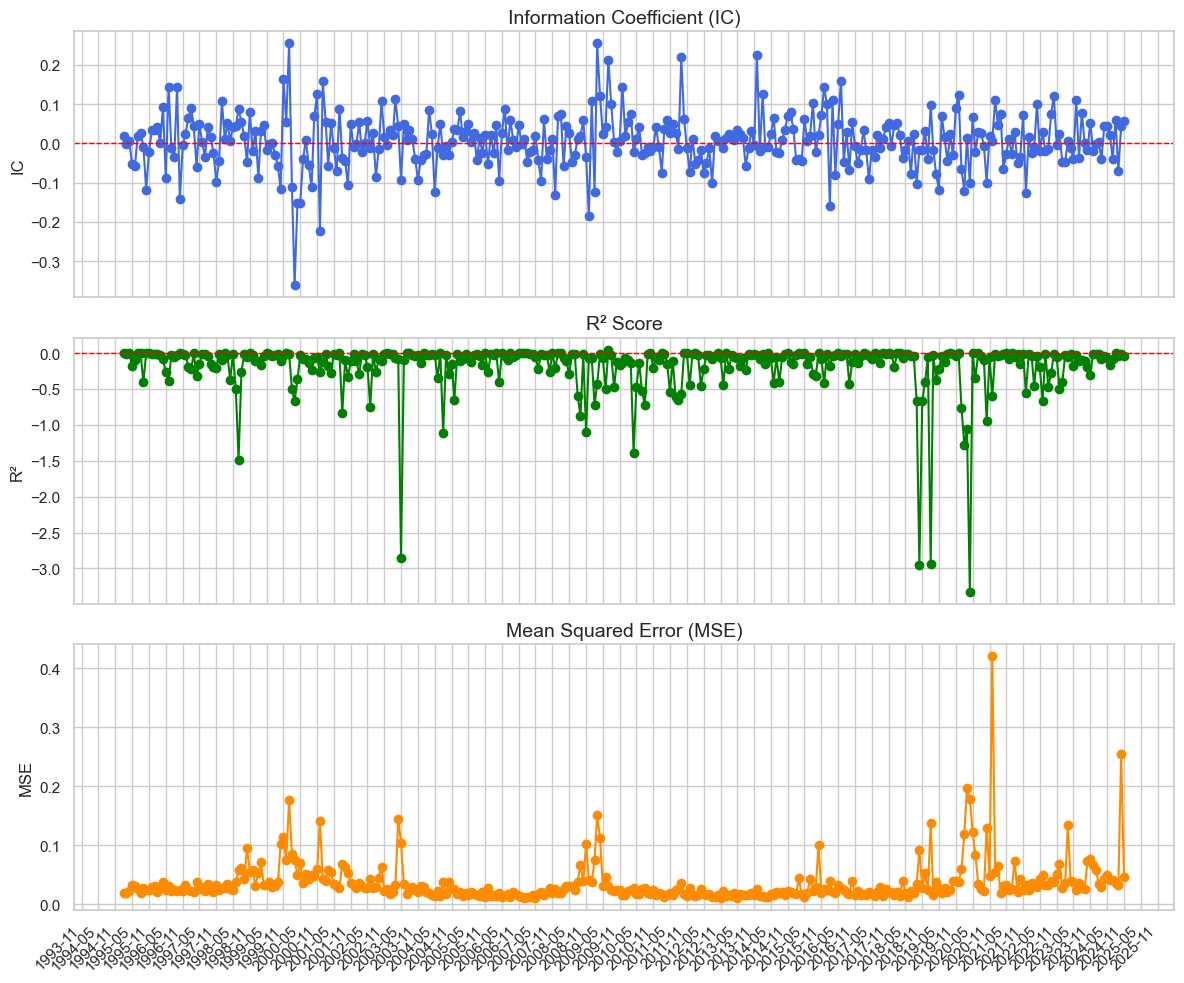

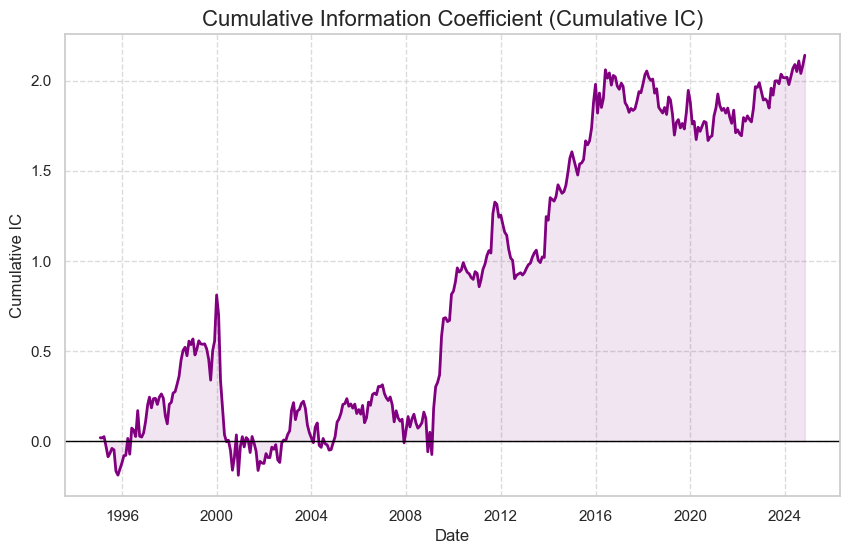

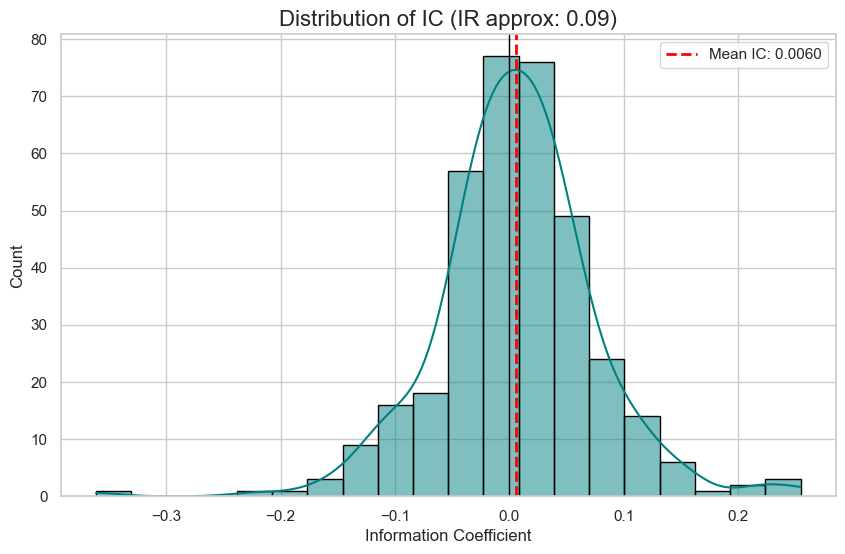

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates

# 1. Pre-process the data for plotting
# Ensure 'month' is datetime objects for proper x-axis formatting
df_results['month_dt'] = pd.to_datetime(df_results['month'])
df_results = df_results.sort_values('month_dt')

sns.set(style="whitegrid")

import matplotlib.dates as mdates


# PLOT 1: Metrics over Time (Clean X-Axis)
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# 1. IC
axes[0].plot(df_results['month_dt'], df_results['IC'], marker='o', linestyle='-', color='royalblue', label='IC')
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('Information Coefficient (IC)', fontsize=14)
axes[0].set_ylabel('IC')

# 2. R2
axes[1].plot(df_results['month_dt'], df_results['R2'], marker='o', linestyle='-', color='green', label='R²')
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_title('R² Score', fontsize=14)
axes[1].set_ylabel('R²')

# 3. MSE
axes[2].plot(df_results['month_dt'], df_results['MSE'], marker='o', linestyle='-', color='darkorange', label='MSE')
axes[2].set_title('Mean Squared Error (MSE)', fontsize=14)
axes[2].set_ylabel('MSE')


#Show a label every 6 months (Good for 2-5 years of data)
axes[2].xaxis.set_major_locator(mdates.MonthLocator(interval=6))


# Format the date string
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate and align the ticks so they don't overlap
plt.xticks(rotation=45, ha='right') 

plt.tight_layout()
plt.show()


# PLOT 2: Cumulative IC (Signal Consistency)
# If the slope is positive and steady, the strategy/model is consistent.
df_results['cumulative_IC'] = df_results['IC'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(df_results['month_dt'], df_results['cumulative_IC'], color='purple', linewidth=2)
plt.fill_between(df_results['month_dt'], df_results['cumulative_IC'], alpha=0.1, color='purple')
plt.title('Cumulative Information Coefficient (Cumulative IC)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Cumulative IC')
plt.axhline(0, color='black', linewidth=1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# PLOT 3: Distribution of IC
plt.figure(figsize=(10, 6))
sns.histplot(df_results['IC'], kde=True, bins=20, color='teal', edgecolor='black')
mean_ic = df_results['IC'].mean()
std_ic = df_results['IC'].std()
ic_ir = mean_ic / std_ic if std_ic != 0 else 0 # Information Ratio approximation

plt.axvline(mean_ic, color='red', linestyle='--', linewidth=2, label=f'Mean IC: {mean_ic:.4f}')
plt.axvline(0, color='black', linewidth=1)
plt.title(f'Distribution of IC (IR approx: {ic_ir:.2f})', fontsize=16)
plt.xlabel('Information Coefficient')
plt.legend()
plt.show()